# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import *
from pyspark.sql.window import *
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import *
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *
from pyspark.ml.regression import *
from pyspark.ml.tuning import *

import re
import datetime
import time

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()

In [3]:
# get the current active SparkContext and its configuration
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.app.name', 'Sparkify Project'),
 ('spark.app.id', 'local-1662650243411'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '5ed1f7e3f37d'),
 ('spark.driver.port', '44031')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Read in the data
df = spark.read.json("mini_sparkify_event_data.json")

In [5]:
# Get the shape of the data set
df.count(), len(df.columns)

(286500, 18)

In [6]:
# Print the schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# observe the data
df.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [8]:
# get descriptive statistics of the data
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

### Look at the breakdown of each variable

In [9]:
df.groupBy('artist').count().sort(col("count").desc()).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|58392|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows



In [10]:
# get a count of how many unique artists are in the data
df.select(countDistinct("artist")).show()

+----------------------+
|count(DISTINCT artist)|
+----------------------+
|                 17655|
+----------------------+



#### A lot of values are null in regards to the artist name. These may be records in the data where no song is actually played.

In [11]:
df.groupBy('auth').count().sort(col("count").desc()).show()

+----------+------+
|      auth| count|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+



#### Here it is easy to see there were 52 cancellations that will help with churn.

In [12]:
df.groupBy('gender').count().sort(col("count").desc()).show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
|  null|  8346|
+------+------+



#### 8,346 records where the gender is null. This will need to be looked into.

In [13]:
df.groupBy('itemInSession').count().sort(col("count").desc()).show()

+-------------+-----+
|itemInSession|count|
+-------------+-----+
|            0| 3278|
|            1| 3125|
|            2| 3067|
|            3| 3013|
|            4| 2977|
|            5| 2925|
|            6| 2886|
|            7| 2857|
|            8| 2816|
|            9| 2771|
|           10| 2717|
|           11| 2672|
|           12| 2636|
|           13| 2600|
|           14| 2561|
|           15| 2523|
|           16| 2497|
|           17| 2461|
|           18| 2417|
|           19| 2381|
+-------------+-----+
only showing top 20 rows



In [14]:
# itemInSession looks like a number.
# It might be worth analyzing it as such
df.describe("itemInSession").show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [15]:
df.groupBy('length').count().sort(col("count").desc()).show()

+---------+-----+
|   length|count|
+---------+-----+
|     null|58392|
| 239.3073| 1205|
|348.57751| 1037|
|201.79546|  908|
|655.77751|  730|
|277.15873|  645|
|219.66322|  585|
|224.67873|  522|
|220.89098|  511|
|236.09424|  450|
|252.21179|  438|
|233.69098|  436|
|122.04363|  412|
|195.94404|  408|
|181.21098|  384|
|225.17506|  379|
|231.81016|  378|
|216.76363|  362|
|302.05342|  345|
|233.89995|  314|
+---------+-----+
only showing top 20 rows



In [16]:
# length looks like a number.
# It might be worth analyzing it that way
df.describe("length").show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



#### That number of 58,392 null values appears again.

In [17]:
df.groupBy('level').count().sort(col("count").desc()).show()

+-----+------+
|level| count|
+-----+------+
| paid|228162|
| free| 58338|
+-----+------+



In [18]:
df.groupBy('location').count().sort(col("count").desc()).show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Los Angeles-Long ...|30131|
|New York-Newark-J...|23684|
|Boston-Cambridge-...|13873|
|Houston-The Woodl...| 9499|
|                null| 8346|
|Charlotte-Concord...| 7780|
|Dallas-Fort Worth...| 7605|
|Louisville/Jeffer...| 6880|
|Philadelphia-Camd...| 5890|
|Chicago-Napervill...| 5114|
|    St. Louis, MO-IL| 4858|
|Phoenix-Mesa-Scot...| 4846|
|Vineland-Bridgeto...| 4825|
|          Wilson, NC| 4659|
|Denver-Aurora-Lak...| 4453|
|           Ionia, MI| 4428|
|San Antonio-New B...| 4373|
|        Danville, VA| 4257|
|Atlanta-Sandy Spr...| 4236|
|New Haven-Milford...| 4007|
+--------------------+-----+
only showing top 20 rows



In [19]:
df.select(countDistinct("location")).show()

+------------------------+
|count(DISTINCT location)|
+------------------------+
|                     114|
+------------------------+



* __That number of 8,346 null values appears again. There must be a pattern to be found.__
* __These look like media markets. It might be interesting to look at the locations by state.__

In [20]:
df.groupBy('method').count().sort(col("count").desc()).show()

+------+------+
|method| count|
+------+------+
|   PUT|261064|
|   GET| 25436|
+------+------+



In [21]:
df.groupBy('page').count().sort(col("count").desc()).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+
only showing top 20 rows



#### Those 52 cancellations show up again and we see each instance of initiating the cancellation process led to a cancellation confirmation. This may be a sign that there is potentially an opportunity where more effort can be put into retaining the subscriber by presenting a special offer or discount.

In [22]:
df.groupBy('registration').count().sort(col("count").desc()).show()

+-------------+-----+
| registration|count|
+-------------+-----+
|1529027541000| 9632|
|         null| 8346|
|1536403972000| 7230|
|1536642109000| 6880|
|1538336771000| 5732|
|1532224335000| 4825|
|1537611935000| 4659|
|1537082511000| 4428|
|1534133898000| 4370|
|1537811988000| 4257|
|1537812949000| 3769|
|1521380675000| 3761|
|1536988041000| 3603|
|1532482662000| 3437|
|1537982255000| 3214|
|1538331630000| 3191|
|1538227408000| 3102|
|1528780738000| 3051|
|1533398428000| 3014|
|1538069638000| 2891|
+-------------+-----+
only showing top 20 rows



In [23]:
df.groupBy('sessionId').count().sort(col("count").desc()).show()

+---------+-----+
|sessionId|count|
+---------+-----+
|     1840| 1322|
|      316| 1247|
|      236|  905|
|      635|  890|
|      368|  799|
|      123|  782|
|       76|  775|
|      731|  773|
|      436|  749|
|      344|  730|
|      827|  714|
|        1|  714|
|      377|  706|
|     2305|  701|
|      132|  677|
|     2056|  677|
|     1483|  671|
|      479|  669|
|     1150|  657|
|     2150|  655|
+---------+-----+
only showing top 20 rows



In [24]:
df.groupBy('song').count().sort(col("count").desc()).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|                null|58392|
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
+--------------------+-----+
only showing top 20 rows



In [25]:
df.groupBy('status').count().sort(col("count").desc()).show()

+------+------+
|status| count|
+------+------+
|   200|259812|
|   307| 26430|
|   404|   258|
+------+------+



In [26]:
df.groupBy('ts').count().sort(col("count").desc()).show()

+-------------+-----+
|           ts|count|
+-------------+-----+
|1543376608000|    4|
|1542848987000|    4|
|1538786140000|    4|
|1542663435000|    3|
|1538778922000|    3|
|1541101796000|    3|
|1539247652000|    3|
|1539996675000|    3|
|1541518229000|    3|
|1539682547000|    3|
|1538512769000|    3|
|1540456067000|    3|
|1540869687000|    3|
|1542820461000|    3|
|1538858551000|    3|
|1538832860000|    3|
|1541544871000|    3|
|1541682160000|    3|
|1541526859000|    3|
|1539721234000|    3|
+-------------+-----+
only showing top 20 rows



In [27]:
df.groupBy('userAgent').count().sort(col("count").desc()).show(57)

+--------------------+-----+
|           userAgent|count|
+--------------------+-----+
|"Mozilla/5.0 (Win...|22751|
|"Mozilla/5.0 (Mac...|19611|
|"Mozilla/5.0 (Mac...|18448|
|"Mozilla/5.0 (Mac...|17348|
|Mozilla/5.0 (Wind...|16700|
|"Mozilla/5.0 (Win...|15395|
|"Mozilla/5.0 (Win...|14598|
|Mozilla/5.0 (Maci...|10300|
|"Mozilla/5.0 (iPa...| 8912|
|Mozilla/5.0 (comp...| 8624|
|                null| 8346|
|"Mozilla/5.0 (Mac...| 8094|
|"Mozilla/5.0 (Win...| 7923|
|"Mozilla/5.0 (Mac...| 7906|
|"Mozilla/5.0 (Win...| 7624|
|"Mozilla/5.0 (iPh...| 6417|
|Mozilla/5.0 (Wind...| 5989|
|"Mozilla/5.0 (Mac...| 5716|
|"Mozilla/5.0 (Win...| 5238|
|"Mozilla/5.0 (Win...| 4917|
|Mozilla/5.0 (Wind...| 4663|
|"Mozilla/5.0 (Win...| 4103|
|Mozilla/5.0 (Wind...| 3655|
|Mozilla/5.0 (Wind...| 3214|
|"Mozilla/5.0 (Win...| 2868|
|"Mozilla/5.0 (X11...| 2842|
|"Mozilla/5.0 (Mac...| 2804|
|"Mozilla/5.0 (iPh...| 2799|
|Mozilla/5.0 (X11;...| 2544|
|"Mozilla/5.0 (iPa...| 2469|
|Mozilla/5.0 (Wind...| 2442|
|Mozilla/5.0 (

#### These values look very similar and may not be too important.

In [28]:
df.groupBy('userAgent').count().sort(col("count").desc()).take(57)

[Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', count=22751),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"', count=19611),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', count=18448),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', count=17348),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', count=16700),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', count=15395),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', count=14598),
 

#### Looking closer, we should be able to extract the browser within the first set of parentheses and the first word before the ";". The values still may not tell us much and may be a candidate for being dropped, but we'll engineer a feature from this column.

### Missingness

In [29]:
# Count the numer of missing records for each column
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [30]:
# Take a look at the records where the user's name, gender, etc. is null
print(df.filter(df.firstName.isNull()).count())
df.filter(df.firstName.isNull()).show()

8346
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|

#### It looks like userId is missing for these records

In [31]:
df.filter(df.firstName.isNull()).groupBy('userId').count().show()

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
+------+-----+



In [32]:
# look at the levels for the records missing user info
df.filter(df.firstName.isNull()).groupBy('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
|     Guest|   97|
+----------+-----+



In [33]:
df.filter(df.firstName.isNull()).groupBy('artist').count().show()

+------+-----+
|artist|count|
+------+-----+
|  null| 8346|
+------+-----+



In [34]:
df.filter(df.firstName.isNull()).groupBy('page').count().show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 4375|
|              About|  429|
|Submit Registration|    5|
|              Login| 3241|
|           Register|   18|
|               Help|  272|
|              Error|    6|
+-------------------+-----+



#### It's clear to see the missingness is a trend and is consistent. The null values that exist in one column seem to align in other columns. There is no user information because these appear to be general actions before an user is actually logged in or they're guests. No song information is available either. These records will be dropped since they cannot help us identifying churn with the userId missing.

In [35]:
# Take a look at the records where the song's name is null
print(df.filter(df.song.isNull()).count())
df.filter(df.song.isNull()).show()

58392
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null| Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null| Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null| Logged In|

In [36]:
df.filter(df.song.isNull()).groupBy('artist').count().show()

+------+-----+
|artist|count|
+------+-----+
|  null|58392|
+------+-----+



In [37]:
df.filter(df.song.isNull()).groupBy('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out| 8249|
| Cancelled|   52|
|     Guest|   97|
| Logged In|49994|
+----------+-----+



In [38]:
df.filter(df.song.isNull()).groupBy('level').count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|16347|
| paid|42045|
+-----+-----+



In [39]:
df.filter(df.song.isNull()).groupBy('userId').count().sort(col("count").desc()).show()

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
|    39| 1630|
|    92| 1285|
|   140| 1216|
|300011| 1113|
|300021|  843|
|200023|  814|
|300017|  796|
|    85|  754|
|   124|  746|
|    42|  684|
|     6|  602|
|    54|  596|
|    29|  575|
|   100|  532|
|300015|  527|
|   126|  525|
|     9|  515|
|   118|  492|
|    98|  490|
+------+-----+
only showing top 20 rows



#### Some of the records where the artist name is missing has user information so these are actions taken when the user is logged in, but is not actually playing music just yet. You can see some people are adding songs to a playlist, liking or disliking songs, or just returning to the home page. It appears there is some intersectionality between the missingness as we've seen thoose 8,249 logged out and 97 guest records. Let's confirm.

In [40]:
# Find the number of records where the missingness does not overlap
print(df.filter(df.song.isNull() & df.firstName.isNotNull()).count(), df.filter(df.song.isNotNull() & df.firstName.isNull()).count())
print(df.filter(df.song.isNull() & df.firstName.isNull()).count(), df.filter(df.song.isNotNull() & df.firstName.isNotNull()).count())
print(df.filter(df.song.isNull()).count(), df.filter(df.song.isNotNull()).count())

50046 0
8346 228108
58392 228108


#### The above cell confirms that the records where the user information is missing, the song name is missing as well. There is another set of records where the song information is missing, but there is user information. In the data, there are no records where the user information is missing while there is song information. Lastly, the rest of the records make up records where there is no missing data. It looks like the missingness can be resolved by removing the records where the user information is null.

### Drop Records Where userId Is Missing

In [41]:
# drop rows with missing values in userid
df = df.filter(df["userId"] != "")

In [42]:
df.count()

278154

### Derive extra variables from existing variables

#### Market

In [43]:
# String Split of the location column after the comma to extract the market
df = df.withColumn("market", split(col("location"), ", ").getItem(1))

In [44]:
df.groupBy('market').count().sort(col("market")).show()

+-----------+-----+
|     market|count|
+-----------+-----+
|         AK| 3563|
|         AL| 2857|
|         AR|  520|
|         AZ| 4846|
|         CA|46771|
|         CO| 7493|
|         CT| 6720|
|DC-VA-MD-WV| 3090|
|         FL|13190|
|         GA| 4236|
|      GA-AL| 2716|
|         IA|  651|
|         IL| 2102|
|   IL-IN-WI| 5114|
|      IL-MO| 1003|
|         IN| 1262|
|         KY| 3462|
|      KY-IN| 6880|
|         LA| 1171|
|      MA-NH|13873|
+-----------+-----+
only showing top 20 rows



In [45]:
# count how many unique markets there are
df.select(countDistinct("market")).show()

+----------------------+
|count(DISTINCT market)|
+----------------------+
|                    58|
+----------------------+



##### There are 114 unique locations in the data. By creating the "market" variable, this was able to be narrowed down to 58.

#### Agent

In [46]:
# We extract browser data from the userAgent column as the first word before the semicolon within the first set of parentheses
agent = udf(lambda x: str(re.findall(r'\((.*?)\)', x)[0].split(";")[0].split()[0]) if x is not None else None, StringType())

# Create new browser column
df = df.withColumn("agent", agent(df.userAgent))
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+------+-------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|market|  agent|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+------+-------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    CA|Windows|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.0942

In [47]:
df.groupBy("agent").count().show()

+----------+------+
|     agent| count|
+----------+------+
|      iPad| 11381|
|       X11|  8961|
|    iPhone| 11192|
| Macintosh|102749|
|compatible| 10684|
|   Windows|133187|
+----------+------+



##### There are 57 unique userAgent values in the data. By creating the "agent" variable, this was able to be narrowed down to 6.

#### Timestamp

In [48]:
#Convert Unix timestamp to timestamp
#df = df.withColumn('longdate', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType())) # convert timestamp to epoch time
df = df.withColumn('shortdate', from_unixtime(col('ts')/1000).cast(DateType()))

In [49]:
# Convert the ts column to extract actual time units
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).hour,IntegerType())
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).day,IntegerType())
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).month,IntegerType())
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).year,IntegerType())

In [50]:
# Creating the columns
df = df \
    .withColumn('hour',get_hour(col('ts'))) \
    .withColumn('day',get_day(col('ts'))) \
    .withColumn('month',get_month(col('ts'))) \
    .withColumn('year',get_year(col('ts')))

In [51]:
df.describe("hour").show()

+-------+-----------------+
|summary|             hour|
+-------+-----------------+
|  count|           278154|
|   mean|12.20457372534639|
| stddev|6.865469990132577|
|    min|                0|
|    max|               23|
+-------+-----------------+



In [52]:
df.describe("year").show()

+-------+------+
|summary|  year|
+-------+------+
|  count|278154|
|   mean|2018.0|
| stddev|   0.0|
|    min|  2018|
|    max|  2018|
+-------+------+



In [53]:
df.describe("month").show()

+-------+------------------+
|summary|             month|
+-------+------------------+
|  count|            278154|
|   mean|10.479022412045126|
| stddev|0.4995894305896185|
|    min|                10|
|    max|                12|
+-------+------------------+



In [54]:
df.describe("day").show()

+-------+------------------+
|summary|               day|
+-------+------------------+
|  count|            278154|
|   mean|15.793574782314833|
| stddev| 8.926525825029135|
|    min|                 1|
|    max|                31|
+-------+------------------+



##### It appears all of the records are from the 4th quarter of 2018.

### Drop unnecessary variables 

In [55]:
# Drop the first and last name of the user and userAgent
df = df.drop("firstName", "lastName", "userAgent")  

In [56]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userId: string (nullable = true)
 |-- market: string (nullable = true)
 |-- agent: string (nullable = true)
 |-- shortdate: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)



In [57]:
df.show()

+--------------------+---------+------+-------------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+------+------+---------+----------+----+---+-----+----+
|              artist|     auth|gender|itemInSession|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|userId|market|    agent| shortdate|hour|day|month|year|
+--------------------+---------+------+-------------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+------+------+---------+----------+----+---+-----+----+
|      Martha Tilston|Logged In|     M|           50|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|    30|    CA|  Windows|2018-10-01|   0|  1|   10|2018|
|    Five Iron Frenzy|Logged In|     M|           79|236.094

# Exploratory Data Analysis
### Define Churn

A column named `churned_ind` will be created and used as the label for the model based on where the variable 'page' equals 'Cancellation Confirmation'. A column labeled `downgraded_ind` will also be created for the events where 'page' equals "Submit Downgrade".

### Explore Data
After creating these variables, exploratory data analysis will be done to observe the behavior for users who stayed versus users who churned. Aggregates between these two groups of users will be explored by observing how much of a specific action they experienced per a certain time unit, a number of songs played, or some other characteristics.

### Users Who Churned

In [58]:
# Get the number of distinct userIds 
df.select("userId").distinct().count()

225

In [59]:
# Identify the users who churned
print(df.select(["userId"]).where(df.page == "Cancellation Confirmation").distinct().count())
df.select(["userId"]).where(df.page == "Cancellation Confirmation").show()

52
+------+
|userId|
+------+
|    18|
|    32|
|   125|
|   105|
|    17|
|   143|
|   101|
|   129|
|   121|
|    51|
|    87|
|   122|
|    12|
|    58|
|    73|
|     3|
|   106|
|   103|
|    28|
|    54|
+------+
only showing top 20 rows



In [60]:
# Identify the users who downgraded their services
print(df.select(["userId"]).where(df.page == "Submit Downgrade").distinct().count())
df.select(["userId"]).where(df.page == "Submit Downgrade").groupby(df.userId).count().sort(col("count").desc()).show(49)

49
+------+-----+
|userId|count|
+------+-----+
|   140|    3|
|    39|    3|
|    85|    2|
|    35|    2|
|   131|    2|
|200023|    2|
|    20|    2|
|100004|    2|
|200003|    2|
|    13|    2|
|    61|    2|
|100018|    2|
|    54|    1|
|    11|    1|
|    30|    1|
|    59|    1|
|    96|    1|
|100016|    1|
|100008|    1|
|100025|    1|
|300002|    1|
|    49|    1|
|   100|    1|
|    95|    1|
|    38|    1|
|    25|    1|
|300004|    1|
|300015|    1|
|    77|    1|
|100009|    1|
|300011|    1|
|300021|    1|
|100015|    1|
|300023|    1|
|    74|    1|
|   103|    1|
|200009|    1|
|    92|    1|
|    81|    1|
|100012|    1|
|200025|    1|
|200020|    1|
|   141|    1|
|     9|    1|
|    24|    1|
|200011|    1|
|    12|    1|
|   109|    1|
|200019|    1|
+------+-----+



#### We have 225 unique users, 49 users who downgraded their services, and 52 users who cancelled their services. There are some users who downgraded their services and then eventually cancelled their services.

In [61]:
# create user-defined function to label churn
flag_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [62]:
# create user-defined function to label a downgrade
flag_downgrade = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [63]:
df = df.withColumn("downgraded", flag_downgrade("page"))

In [64]:
df = df.withColumn("churned", flag_churn("page"))

In [65]:
# Assign the flags at an user level
df = df.withColumn("churn_ind", max('churned').over(Window.partitionBy('userId')))
df = df.withColumn("downgrade_ind", max('downgraded').over(Window.partitionBy('userId')))

In [66]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userId: string (nullable = true)
 |-- market: string (nullable = true)
 |-- agent: string (nullable = true)
 |-- shortdate: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- churned: integer (nullable = true)
 |-- churn_ind: integer (nullable = true)
 |-- downgrade_ind: integer (nullable = t

In [67]:
df.groupBy('downgraded').count().sort(col("count").desc()).show()

+----------+------+
|downgraded| count|
+----------+------+
|         0|278091|
|         1|    63|
+----------+------+



In [68]:
df.groupBy('churned').count().sort(col("count").desc()).show()

+-------+------+
|churned| count|
+-------+------+
|      0|278102|
|      1|    52|
+-------+------+



In [69]:
# Wrtie cleaned data file to folder
#df.write.csv("Sparkify_Data_Cleaned.csv",header = 'true')

In [70]:
# Read in cleaned data set
df_clean = spark.read.csv("Sparkify_Data_Cleaned.csv",header = 'true')
df_clean.head()

Row(artist=None, auth='Logged In', gender='M', itemInSession='0', length=None, level='free', location='New York-Newark-Jersey City, NY-NJ-PA', method='GET', page='Home', registration='1538227408000', sessionId='125', song=None, status='200', ts='1538387004000', userId='126', market='NY-NJ-PA', agent='Windows', shortdate='2018-10-01', hour='9', day='1', month='10', year='2018', downgraded='0', churned='0', churn_ind='0', downgrade_ind='0')

In [71]:
df_clean = df_clean.withColumn("itemInSession", df_clean["itemInSession"].cast(IntegerType()))

In [72]:
# Create a data set with one record per userId to indicate if they churned or not
churned_df = df.sort(col("userId"),col("churned").desc()).dropDuplicates(["userId"])
churned_df.count()

225

In [73]:
churned_df = churned_df.groupBy(["churned"]).count()

In [74]:
# Create a data set with one record per userId to indicate if they downgraded or not
downgraded_df = df.sort(col("userId"),col("downgraded").desc()).dropDuplicates(["userId"])
downgraded_df.count()

225

In [75]:
downgraded_df = downgraded_df.groupBy(["downgraded"]).count()

### EDA for Churn vs Not Churn and Downgrade vs Not Downgrade

In [76]:
# Count the number of users who churned/downgraded vs not churned/downgraded for the status distribution
# churn_ind = 1 means customer churned, churn_ind = 0 means customer did not churn
# downgrade_ind = 1 means customer downgraded, downgrade_ind = 0 means customer did not downgrade
df_clean.groupby(['churn_ind', 'downgrade_ind']).agg(countDistinct('userId').alias('user_count')).sort("churn_ind","downgrade_ind").show()

+---------+-------------+----------+
|churn_ind|downgrade_ind|user_count|
+---------+-------------+----------+
|        0|            0|       133|
|        0|            1|        40|
|        1|            0|        43|
|        1|            1|         9|
+---------+-------------+----------+



In [77]:
# transform to panda dataframe for visualization
churned_df = churned_df.toPandas()
downgraded_df = downgraded_df.toPandas()
df_pd = df_clean.toPandas()

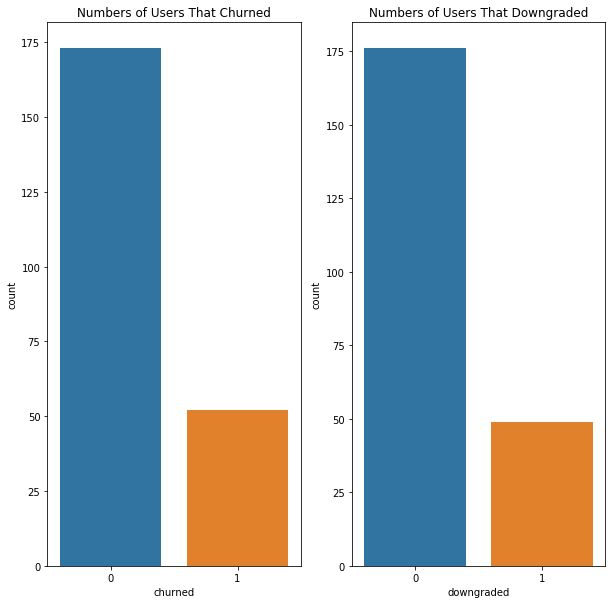

In [78]:
# Plot data as bar charts (1 - churned/downgraded)
fig = plt.figure(figsize=[10,10])

plt.subplot(1, 2, 1)
ax = sns.barplot(data = churned_df, x = 'churned', y='count')
plt.title("Numbers of Users That Churned");

plt.subplot(1, 2, 2)
ax = sns.barplot(data = downgraded_df, x = 'downgraded', y='count')
plt.title("Numbers of Users That Downgraded");

#### Let's observe the churn/downgrade records by other categories. We'll plot bar plots showing the distribution between users who churned and users who did not
(namely: auth, gender, level, agent, market, status)

In [79]:
# transform eacg subset of data to a panda dataframe for visualization
auth_churn = df_clean.drop_duplicates(['userId', 'auth']).groupby(['churn_ind', 'auth']).count().sort("churn_ind").toPandas()
gender_churn = df_clean.drop_duplicates(['userId', 'gender']).groupby(['churn_ind', 'gender']).count().sort("churn_ind").toPandas()
level_churn = df_clean.drop_duplicates(['userId', 'level']).groupby(['churn_ind', 'level']).count().sort("churn_ind").toPandas()
agent_churn = df_clean.drop_duplicates(['userId', 'agent']).groupby(['churn_ind', 'agent']).count().sort("churn_ind").toPandas()
market_churn = df_clean.drop_duplicates(['userId', 'market']).groupby(['churn_ind', 'market']).count().sort("churn_ind").toPandas()
status_churn = df_clean.drop_duplicates(['userId', 'status']).groupby(['churn_ind', 'status']).count().sort("churn_ind").toPandas()

auth_downgrade = df_clean.drop_duplicates(['userId', 'auth']).groupby(['downgrade_ind', 'auth']).count().sort("downgrade_ind").toPandas()
gender_downgrade = df_clean.drop_duplicates(['userId', 'gender']).groupby(['downgrade_ind', 'gender']).count().sort("downgrade_ind").toPandas()
level_downgrade = df_clean.drop_duplicates(['userId', 'level']).groupby(['downgrade_ind', 'level']).count().sort("downgrade_ind").toPandas()
agent_downgrade = df_clean.drop_duplicates(['userId', 'agent']).groupby(['downgrade_ind', 'agent']).count().sort("downgrade_ind").toPandas()
market_downgrade = df_clean.drop_duplicates(['userId', 'market']).groupby(['downgrade_ind', 'market']).count().sort("downgrade_ind").toPandas()
status_downgrade = df_clean.drop_duplicates(['userId', 'status']).groupby(['downgrade_ind', 'status']).count().sort("downgrade_ind").toPandas()

In [84]:
level_churn

,churn_ind,level,count
0,0,paid,129
1,0,free,149
2,1,paid,36
3,1,free,46


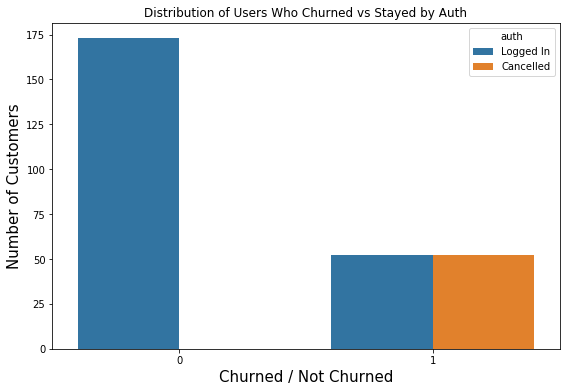

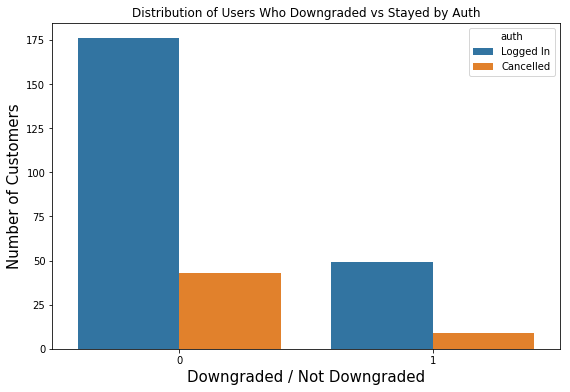

In [85]:
fig = plt.figure(figsize=[20,6])
plt.subplot(1, 2, 1)
plt.title('Distribution of Users Who Churned vs Stayed by Auth')
ax = sns.barplot(x = 'churn_ind', y = 'count',data = auth_churn, hue = 'auth')
ax.set_xlabel("Churned / Not Churned", fontsize = 15)
ax.set_ylabel("Number of Customers", fontsize = 15)
plt.show()

fig = plt.figure(figsize=[20,6])
plt.subplot(1, 2, 2)
plt.title('Distribution of Users Who Downgraded vs Stayed by Auth')
ax = sns.barplot(x = 'downgrade_ind', y = 'count',data = auth_downgrade, hue = 'auth')
ax.set_xlabel("Downgraded / Not Downgraded", fontsize = 15)
ax.set_ylabel("Number of Customers", fontsize = 15)
plt.show()

In [86]:
# Count the number of users who churned/downgraded vs not churned/downgraded for the service in authencation distribution
# churn_ind = 1 means customer churned, churn_ind = 0 means customer did not churn
# downgrade_ind = 1 means customer downgraded, downgrade_ind = 0 means customer did not downgrade
df_clean.groupby(['churn_ind', 'auth']).agg(countDistinct('userId').alias('user_count')).sort("churn_ind","auth").show()
df_clean.groupby(['downgrade_ind', 'auth']).agg(countDistinct('userId').alias('user_count')).sort("downgrade_ind","auth").show()

+---------+---------+----------+
|churn_ind|     auth|user_count|
+---------+---------+----------+
|        0|Logged In|       173|
|        1|Cancelled|        52|
|        1|Logged In|        52|
+---------+---------+----------+

+-------------+---------+----------+
|downgrade_ind|     auth|user_count|
+-------------+---------+----------+
|            0|Cancelled|        43|
|            0|Logged In|       176|
|            1|Cancelled|         9|
|            1|Logged In|        49|
+-------------+---------+----------+



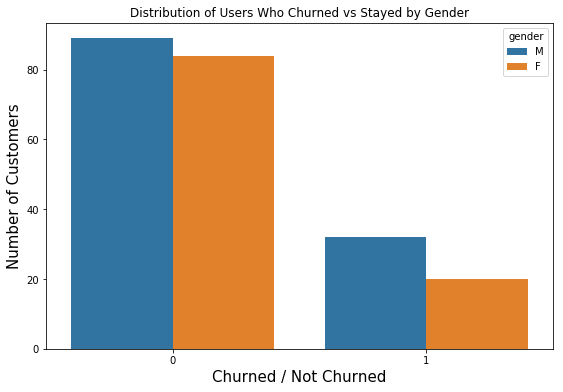

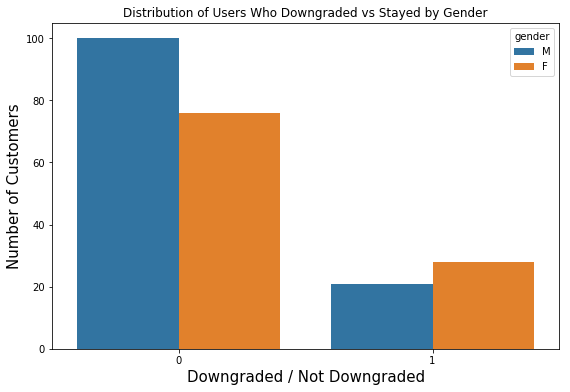

In [87]:
fig = plt.figure(figsize=[20,6])
plt.subplot(1, 2, 1)
plt.title('Distribution of Users Who Churned vs Stayed by Gender')
ax = sns.barplot(x = 'churn_ind', y = 'count',data = gender_churn, hue = 'gender')
ax.set_xlabel("Churned / Not Churned", fontsize = 15)
ax.set_ylabel("Number of Customers", fontsize = 15)
plt.show()

fig = plt.figure(figsize=[20,6])
plt.subplot(1, 2, 2)
plt.title('Distribution of Users Who Downgraded vs Stayed by Gender')
ax = sns.barplot(x = 'downgrade_ind', y = 'count',data = gender_downgrade, hue = 'gender')
ax.set_xlabel("Downgraded / Not Downgraded", fontsize = 15)
ax.set_ylabel("Number of Customers", fontsize = 15)
plt.show()

In [88]:
# Count the number of users who churned/downgraded vs not churned/downgraded for the service in gender distribution
# churn_ind = 1 means customer churned, churn_ind = 0 means customer did not churn
# downgrade_ind = 1 means customer downgraded, downgrade_ind = 0 means customer did not downgrade
df_clean.groupby(['churn_ind', 'gender']).agg(countDistinct('userId').alias('user_count')).sort("churn_ind","gender").show()
df_clean.groupby(['downgrade_ind', 'gender']).agg(countDistinct('userId').alias('user_count')).sort("downgrade_ind","gender").show()

+---------+------+----------+
|churn_ind|gender|user_count|
+---------+------+----------+
|        0|     F|        84|
|        0|     M|        89|
|        1|     F|        20|
|        1|     M|        32|
+---------+------+----------+

+-------------+------+----------+
|downgrade_ind|gender|user_count|
+-------------+------+----------+
|            0|     F|        76|
|            0|     M|       100|
|            1|     F|        28|
|            1|     M|        21|
+-------------+------+----------+



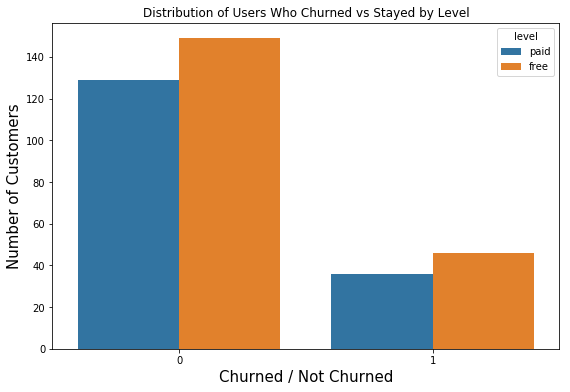

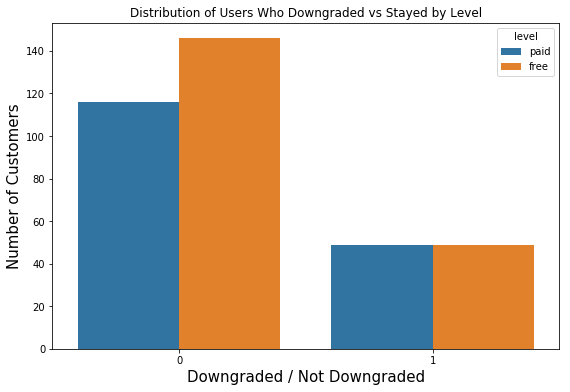

In [89]:
fig = plt.figure(figsize=[20,6])
plt.subplot(1, 2, 1)
plt.title('Distribution of Users Who Churned vs Stayed by Level')
ax = sns.barplot(x = 'churn_ind', y = 'count',data = level_churn, hue = 'level')
ax.set_xlabel("Churned / Not Churned", fontsize = 15)
ax.set_ylabel("Number of Customers", fontsize = 15)
plt.show()

fig = plt.figure(figsize=[20,6])
plt.subplot(1, 2, 2)
plt.title('Distribution of Users Who Downgraded vs Stayed by Level')
ax = sns.barplot(x = 'downgrade_ind', y = 'count',data = level_downgrade, hue = 'level')
ax.set_xlabel("Downgraded / Not Downgraded", fontsize = 15)
ax.set_ylabel("Number of Customers", fontsize = 15)
plt.show()

In [90]:
# Count the number of users who churned/downgraded vs not churned/downgraded for the service in customer level distribution
# churn_ind = 1 means customer churned, churn_ind = 0 means customer did not churn
# downgrade_ind = 1 means customer downgraded, downgrade_ind = 0 means customer did not downgrade
df_clean.groupby(['churn_ind', 'level']).agg(countDistinct('userId').alias('user_count')).sort("churn_ind","level").show()
df_clean.groupby(['downgrade_ind', 'level']).agg(countDistinct('userId').alias('user_count')).sort("downgrade_ind","level").show()

+---------+-----+----------+
|churn_ind|level|user_count|
+---------+-----+----------+
|        0| free|       149|
|        0| paid|       129|
|        1| free|        46|
|        1| paid|        36|
+---------+-----+----------+

+-------------+-----+----------+
|downgrade_ind|level|user_count|
+-------------+-----+----------+
|            0| free|       146|
|            0| paid|       116|
|            1| free|        49|
|            1| paid|        49|
+-------------+-----+----------+



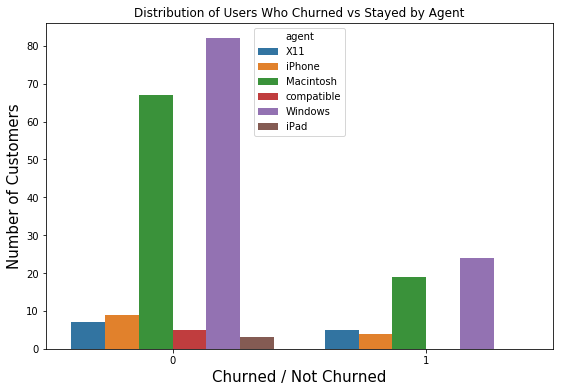

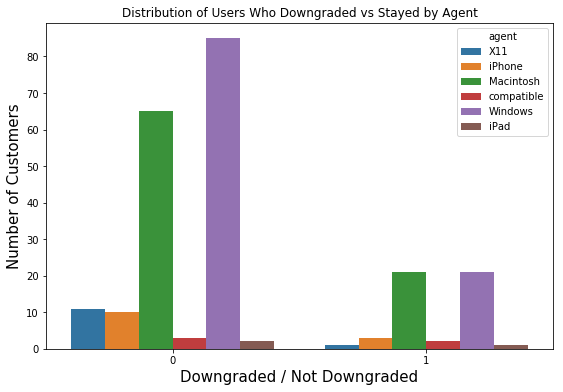

In [91]:
fig = plt.figure(figsize=[20,6])

plt.subplot(1, 2, 1)
plt.title('Distribution of Users Who Churned vs Stayed by Agent')
ax = sns.barplot(x = 'churn_ind', y = 'count',data = agent_churn, hue = 'agent')
ax.set_xlabel("Churned / Not Churned", fontsize = 15)
ax.set_ylabel("Number of Customers", fontsize = 15)
plt.show()

fig = plt.figure(figsize=[20,6])
plt.subplot(1, 2, 2)
plt.title('Distribution of Users Who Downgraded vs Stayed by Agent')
ax = sns.barplot(x = 'downgrade_ind', y = 'count',data = agent_downgrade, hue = 'agent')
ax.set_xlabel("Downgraded / Not Downgraded", fontsize = 15)
ax.set_ylabel("Number of Customers", fontsize = 15)
plt.show()

In [92]:
# Count the number of users who churned/downgraded vs not churned/downgraded for the service in browser distribution
# churn_ind = 1 means customer churned, churn_ind = 0 means customer did not churn
# downgrade_ind = 1 means customer downgraded, downgrade_ind = 0 means customer did not downgrade
df_clean.groupby(['churn_ind', 'agent']).agg(countDistinct('userId').alias('user_count')).sort("churn_ind","agent").show()
df_clean.groupby(['downgrade_ind', 'agent']).agg(countDistinct('userId').alias('user_count')).sort("downgrade_ind","agent").show()

+---------+----------+----------+
|churn_ind|     agent|user_count|
+---------+----------+----------+
|        0| Macintosh|        67|
|        0|   Windows|        82|
|        0|       X11|         7|
|        0|compatible|         5|
|        0|      iPad|         3|
|        0|    iPhone|         9|
|        1| Macintosh|        19|
|        1|   Windows|        24|
|        1|       X11|         5|
|        1|    iPhone|         4|
+---------+----------+----------+

+-------------+----------+----------+
|downgrade_ind|     agent|user_count|
+-------------+----------+----------+
|            0| Macintosh|        65|
|            0|   Windows|        85|
|            0|       X11|        11|
|            0|compatible|         3|
|            0|      iPad|         2|
|            0|    iPhone|        10|
|            1| Macintosh|        21|
|            1|   Windows|        21|
|            1|       X11|         1|
|            1|compatible|         2|
|            1|      iPad|   

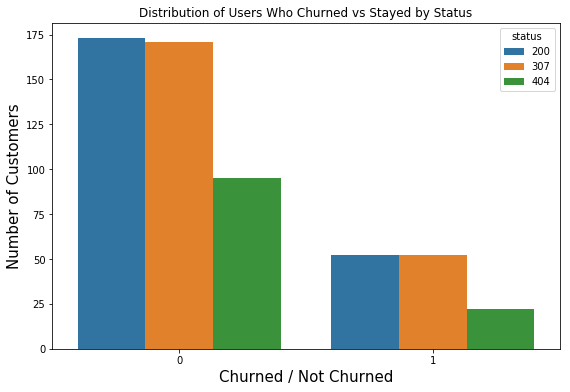

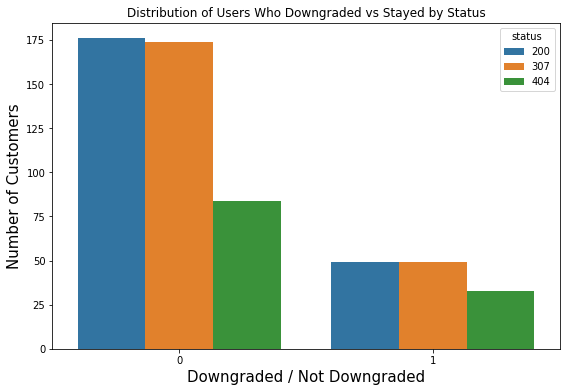

In [93]:
fig = plt.figure(figsize=[20,6])

plt.subplot(1, 2, 1)
plt.title('Distribution of Users Who Churned vs Stayed by Status')
ax = sns.barplot(x = 'churn_ind', y = 'count',data = status_churn, hue = 'status')
ax.set_xlabel("Churned / Not Churned", fontsize = 15)
ax.set_ylabel("Number of Customers", fontsize = 15)
plt.show()

fig = plt.figure(figsize=[20,6])
plt.subplot(1, 2, 2)
plt.title('Distribution of Users Who Downgraded vs Stayed by Status')
ax = sns.barplot(x = 'downgrade_ind', y = 'count',data = status_downgrade, hue = 'status')
ax.set_xlabel("Downgraded / Not Downgraded", fontsize = 15)
ax.set_ylabel("Number of Customers", fontsize = 15)
plt.show()

In [94]:
# Count the number of users who churned/downgraded vs not churned/downgraded for the status distribution
# churn_ind = 1 means customer churned, churn_ind = 0 means customer did not churn
# downgrade_ind = 1 means customer downgraded, downgrade_ind = 0 means customer did not downgrade
df_clean.groupby(['churn_ind', 'status']).agg(countDistinct('userId').alias('user_count')).sort("churn_ind","status").show()
df_clean.groupby(['downgrade_ind', 'status']).agg(countDistinct('userId').alias('user_count')).sort("downgrade_ind","status").show()

+---------+------+----------+
|churn_ind|status|user_count|
+---------+------+----------+
|        0|   200|       173|
|        0|   307|       171|
|        0|   404|        95|
|        1|   200|        52|
|        1|   307|        52|
|        1|   404|        22|
+---------+------+----------+

+-------------+------+----------+
|downgrade_ind|status|user_count|
+-------------+------+----------+
|            0|   200|       176|
|            0|   307|       174|
|            0|   404|        84|
|            1|   200|        49|
|            1|   307|        49|
|            1|   404|        33|
+-------------+------+----------+



# Feature Engineering
Once familiarized with the data, the most promising features will be built/used to train your model on.

Steps include:
- Write a script to extract the necessary features 
- Ensure that your script is scalable
- Debug if necessary

In [95]:
# Create a variable to show how long the user has been a member
cancel = df_clean.groupBy('userId').agg(max('ts').alias('last_interaction'))
df_clean = cancel.join(df_clean, on='userId').withColumn('time_as_user', ((col('last_interaction')-col('registration'))/86400000).cast(IntegerType()))
df_clean.show(2)

+------+----------------+-------------+---------+------+-------------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------+-------+----------+----+---+-----+----+----------+-------+---------+-------------+------------+
|userId|last_interaction|       artist|     auth|gender|itemInSession|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|  market|  agent| shortdate|hour|day|month|year|downgraded|churned|churn_ind|downgrade_ind|time_as_user|
+------+----------------+-------------+---------+------+-------------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------+-------+----------+----+---+-----+----+----------+-------+---------+-------------+------------+
|   126|   1543592476000|         null|Logged In|     M|            0|     null| free|New York-Newark-J...|   GET|    Home|1538

In [115]:
# how long have users been using the service on average by churn
time_as_user_df = df_clean.groupby('churned').agg({"time_as_user":"avg"})
df_clean.groupby('churned').agg({"time_as_user":"avg"}).show()

+-------+-----------------+
|churned|avg(time_as_user)|
+-------+-----------------+
|      0|88.54693961208477|
|      1|56.80769230769231|
+-------+-----------------+



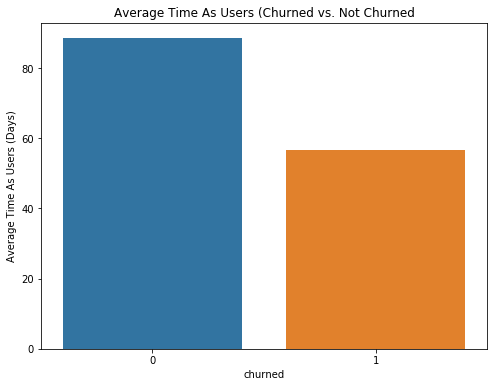

In [118]:
# convert to a pandas df
time_as_user_df = time_as_user_df.toPandas()

#plot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = time_as_user_df, x = 'churned', y='avg(time_as_user)')
plt.title("Average Time As Users (Churned vs. Not Churned")
plt.ylabel("Average Time As Users (Days)");

In [100]:
# Create variables to determine how much the user uses the app daily (actions in the app)
daily_actions = df_clean.groupby('userId','shortdate').agg(max('itemInSession')).groupBy('userId').avg('max(itemInSession)').\
                                                            withColumnRenamed('avg(max(itemInSession))', 'daily_actions')
df_clean = df_clean.join(daily_actions, on='userId')
df_clean = df_clean.drop('itemInSession')
df_clean.show(2)

+------+----------------+--------------------+---------+------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+------+------+----------+----+---+-----+----+----------+-------+---------+-------------+------------+-----------------+
|userId|last_interaction|              artist|     auth|gender|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|market| agent| shortdate|hour|day|month|year|downgraded|churned|churn_ind|downgrade_ind|time_as_user|    daily_actions|
+------+----------------+--------------------+---------+------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+------+------+----------+----+---+-----+----+----------+-------+---------+-------------+------------+-----------------+
|100010|   1542823952000|Sleeping With Sirens|Logged In|     F|202.97098| free|Bridgeport-Stam

In [120]:
# how many daily actions does an user have on average by churn
daily_actions_df = df_clean.groupby('churned').agg({"daily_actions":"avg"})
df_clean.groupby('churned').agg({"daily_actions":"avg"}).show()

+-------+------------------+
|churned|avg(daily_actions)|
+-------+------------------+
|      0|125.59046013646415|
|      1| 89.11598218376122|
+-------+------------------+



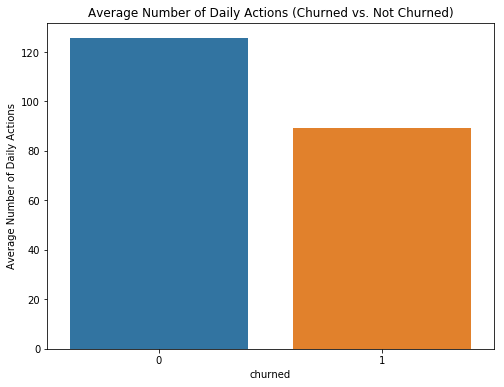

In [123]:
# convert to a pandas df
daily_actions_df = daily_actions_df.toPandas()

#plot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = daily_actions_df, x = 'churned', y='avg(daily_actions)')
plt.title("Average Number of Daily Actions (Churned vs. Not Churned)")
plt.ylabel("Average Number of Daily Actions");

In [102]:
# songs played per day
daily_songs = df_clean.groupBy('userId','shortdate').agg(countDistinct('song').alias('songs')).sort('userId')
songs_per_day = daily_songs.groupBy('userId').avg('songs').withColumnRenamed('avg(songs)', 'songs_per_day')
df_clean = df_clean.join(songs_per_day, on='userId')
df_clean.show(2)

+------+----------------+--------------------+---------+------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+------+------+----------+----+---+-----+----+----------+-------+---------+-------------+------------+-----------------+------------------+
|userId|last_interaction|              artist|     auth|gender|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|market| agent| shortdate|hour|day|month|year|downgraded|churned|churn_ind|downgrade_ind|time_as_user|    daily_actions|     songs_per_day|
+------+----------------+--------------------+---------+------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+------+------+----------+----+---+-----+----+----------+-------+---------+-------------+------------+-----------------+------------------+
|100010|   1542823952000|Sleeping Wit

In [124]:
# how many songs per day does an user play on average by churn
songs_per_day_df = df_clean.groupby('churned').agg({"songs_per_day":"avg"})
df_clean.groupby('churned').agg({"songs_per_day":"avg"}).show()

+-------+------------------+
|churned|avg(songs_per_day)|
+-------+------------------+
|      0|  82.2059531600284|
|      1| 60.44755800236331|
+-------+------------------+



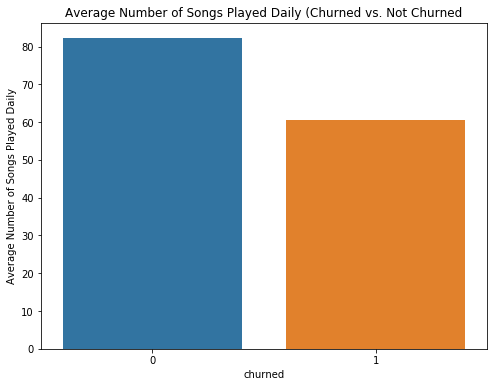

In [125]:
# convert to a pandas df
songs_per_day_df = songs_per_day_df.toPandas()

#plot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = songs_per_day_df, x = 'churned', y='avg(songs_per_day)')
plt.title("Average Number of Songs Played Daily (Churned vs. Not Churned")
plt.ylabel("Average Number of Songs Played Daily");

In [105]:
# amount of songs played per session
session_songs = df_clean.groupBy('userId','sessionId').agg(countDistinct('song').alias('session_songs')).sort('userId')
songs_per_session = session_songs.groupBy('userId').avg('session_songs').withColumnRenamed('avg(session_songs)', 'songs_per_session')
df_clean = df_clean.join(songs_per_session, on='userId')
df_clean.show(2)

+------+----------------+--------------------+---------+------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+------+------+----------+----+---+-----+----+----------+-------+---------+-------------+------------+-----------------+------------------+------------------+
|userId|last_interaction|              artist|     auth|gender|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|market| agent| shortdate|hour|day|month|year|downgraded|churned|churn_ind|downgrade_ind|time_as_user|    daily_actions|     songs_per_day| songs_per_session|
+------+----------------+--------------------+---------+------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+------+------+----------+----+---+-----+----+----------+-------+---------+-------------+------------+-----------------+------------------+

In [126]:
# how many songs per session does an user play on average by churn
songs_per_session_df = df_clean.groupby('churned').agg({"songs_per_session":"avg"})
df_clean.groupby('churned').agg({"songs_per_session":"avg"}).show()

+-------+----------------------+
|churned|avg(songs_per_session)|
+-------+----------------------+
|      0|     84.71417836925623|
|      1|     60.82871375335593|
+-------+----------------------+



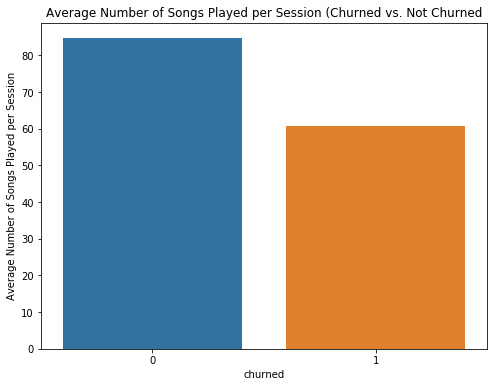

In [129]:
# convert to a pandas df
songs_per_session_df = songs_per_session_df.toPandas()

#plot
plt.figure(figsize = [8,6])
ax = sns.barplot(data = songs_per_session_df, x = 'churned', y='avg(songs_per_session)')
plt.title("Average Number of Songs Played per Session (Churned vs. Not Churned")
plt.ylabel("Average Number of Songs Played per Session");

In [94]:
# Create a data set with one record per userId to indicate if they churned or not
levels = df_clean.sort(col("userId"),col("ts").desc()).dropDuplicates(["userId"])
levels = levels.select(['userId', 'level'])
df_clean = df_clean.drop('level')
df_clean = df_clean.join(levels, on='userId')
df_clean.show(2)

+------+----------------+--------------------+---------+------+---------+--------------------+------+--------+-------------+---------+--------------------+------+-------------+------+------+----------+----+---+-----+----+----------+-------+---------+-------------+------------+-----------------+------------------+------------------+-----+
|userId|last_interaction|              artist|     auth|gender|   length|            location|method|    page| registration|sessionId|                song|status|           ts|market| agent| shortdate|hour|day|month|year|downgraded|churned|churn_ind|downgrade_ind|time_as_user|    daily_actions|     songs_per_day| songs_per_session|level|
+------+----------------+--------------------+---------+------+---------+--------------------+------+--------+-------------+---------+--------------------+------+-------------+------+------+----------+----+---+-----+----+----------+-------+---------+-------------+------------+-----------------+------------------+------

In [95]:
df_clean.printSchema()

root
 |-- userId: string (nullable = true)
 |-- last_interaction: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- length: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- market: string (nullable = true)
 |-- agent: string (nullable = true)
 |-- shortdate: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- downgraded: string (nullable = true)
 |-- churned: string (nullable = true)
 |-- churn_ind: string (nullable = true)
 |-- downgrade_ind: string (nullable = true)
 |-- time_as_user: intege

#### Recode variables to numeric representation

In [96]:
df_clean = df_clean.withColumn("gender_ind", when(df_clean.gender == "M",1)
                                 .when(df_clean.gender == "F",0)
                                 .otherwise(df_clean.gender))

In [97]:
df_clean = df_clean.withColumn("level_ind", when(df_clean.level == "paid",1)
                                 .when(df_clean.level == "free",0)
                                 .otherwise(df_clean.level))

In [98]:
df_clean = df_clean.withColumn("downgrade_ind",col("downgrade_ind").cast("integer"))
df_clean = df_clean.withColumn("label",col("churn_ind").cast("integer"))
df_clean = df_clean.withColumn("gender_ind",col("gender_ind").cast("integer"))
df_clean = df_clean.withColumn("level_ind",col("level_ind").cast("integer"))

In [99]:
df_clean = df_clean.withColumn("churn_ind",col("churn_ind").cast("integer"))

In [100]:
df_clean.printSchema()

root
 |-- userId: string (nullable = true)
 |-- last_interaction: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- length: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- market: string (nullable = true)
 |-- agent: string (nullable = true)
 |-- shortdate: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- downgraded: string (nullable = true)
 |-- churned: string (nullable = true)
 |-- churn_ind: integer (nullable = true)
 |-- downgrade_ind: integer (nullable = true)
 |-- time_as_user: inte

In [101]:
# Drop unneccessary variables and keep one record per user
df_final = df_clean.drop('last_interaction', 'artist', 'auth', 'gender', 'length', 'location', 'method', 'page',\
                        'registration', 'sessionId', 'song', 'status', 'ts', 'market', 'agent', 'shortdate', 'hour', 'day',\
                        'month', 'year', 'churned', 'churn_ind', 'downgraded', 'level').dropDuplicates(['userId']).sort("userId")

In [102]:
df_final.show(10)

+------+-------------+------------+------------------+-----------------+-----------------+----------+---------+-----+
|userId|downgrade_ind|time_as_user|     daily_actions|    songs_per_day|songs_per_session|gender_ind|level_ind|label|
+------+-------------+------------+------------------+-----------------+-----------------+----------+---------+-----+
|    10|            0|          51|            154.75|            83.25|            110.0|         1|        1|    0|
|   100|            1|          64|118.33333333333333| 79.9090909090909|             75.4|         1|        1|    0|
|100001|            0|          44|              62.0|             66.0|            33.25|         0|        0|    1|
|100002|            0|         160|              69.6|             39.0|             48.5|         0|        1|    0|
|100003|            0|          22|              41.0|             25.5|             25.5|         0|        0|    1|
|100004|            1|         172| 76.42105263157895|48

In [103]:
df_final = df_final.drop('userId')

In [104]:
# Wrtie cleaned data file to folder
#df_final.write.csv("Sparkify_Data_Final.csv",header = 'true')

In [146]:
# Read in cleaned data set
df_final = spark.read.csv("Sparkify_Data_Final.csv",header = 'true')
df_final.head()

Row(downgrade_ind='0', time_as_user='116', daily_actions='374.11764705882354', songs_per_day='148.1764705882353', songs_per_session='272.77777777777777', gender_ind='1', level_ind='1', label='0')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Train Pipeline
- Split data into train and test sets
- Train pipeline

In [147]:
# make sure each variable is presented as a number
for col in df_final.columns:
    df_final = df_final.withColumn(col, df_final[col].cast('float'))

In [148]:
# verify it worked
df_final.printSchema()

root
 |-- downgrade_ind: float (nullable = true)
 |-- time_as_user: float (nullable = true)
 |-- daily_actions: float (nullable = true)
 |-- songs_per_day: float (nullable = true)
 |-- songs_per_session: float (nullable = true)
 |-- gender_ind: float (nullable = true)
 |-- level_ind: float (nullable = true)
 |-- label: float (nullable = true)



In [149]:
# feature transformer that merges multiple columns into a vector column
VA = VectorAssembler(inputCols = ["downgrade_ind", "time_as_user", "daily_actions", "songs_per_day", "songs_per_session", "gender_ind", "level_ind"], outputCol = "features_vector")

In [150]:
df_final = VA.transform(df_final)
df_final.show()

+-------------+------------+-------------+-------------+-----------------+----------+---------+-----+--------------------+
|downgrade_ind|time_as_user|daily_actions|songs_per_day|songs_per_session|gender_ind|level_ind|label|     features_vector|
+-------------+------------+-------------+-------------+-----------------+----------+---------+-----+--------------------+
|          0.0|       116.0|    374.11765|    148.17647|        272.77777|       1.0|      1.0|  0.0|[0.0,116.0,374.11...|
|          1.0|        83.0|    129.03703|   108.388885|         68.03488|       0.0|      0.0|  0.0|[1.0,83.0,129.037...|
|          0.0|        75.0|    145.05556|     97.55556|        102.70588|       0.0|      1.0|  0.0|[0.0,75.0,145.055...|
|          0.0|        95.0|    128.47368|     89.36842|         99.23529|       1.0|      1.0|  0.0|[0.0,95.0,128.473...|
|          0.0|        69.0|    141.11111|    82.333336|        105.14286|       0.0|      1.0|  0.0|[0.0,69.0,141.111...|
|          1.0| 

In [151]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler(inputCol="features_vector", outputCol="features", withStd=True)

In [152]:
# fit to the data
scaler_model = scaler.fit(df_final)

In [153]:
# transform the data
df_final = scaler_model.transform(df_final)

In [154]:
df_final.show(5)

+-------------+------------+-------------+-------------+-----------------+----------+---------+-----+--------------------+--------------------+
|downgrade_ind|time_as_user|daily_actions|songs_per_day|songs_per_session|gender_ind|level_ind|label|     features_vector|            features|
+-------------+------------+-------------+-------------+-----------------+----------+---------+-----+--------------------+--------------------+
|          0.0|       116.0|    374.11765|    148.17647|        272.77777|       1.0|      1.0|  0.0|[0.0,116.0,374.11...|[0.0,3.0812855079...|
|          1.0|        83.0|    129.03703|   108.388885|         68.03488|       0.0|      0.0|  0.0|[1.0,83.0,129.037...|[2.41746889207614...|
|          0.0|        75.0|    145.05556|     97.55556|        102.70588|       0.0|      1.0|  0.0|[0.0,75.0,145.055...|[0.0,1.9922104577...|
|          0.0|        95.0|    128.47368|     89.36842|         99.23529|       1.0|      1.0|  0.0|[0.0,95.0,128.473...|[0.0,2.5234665

In [155]:
df_final.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



#### Train-Test-Split

In [157]:
# Split the data
train, test, validation = df_final.randomSplit([0.5, 0.25, 0.25], seed=42)

In [158]:
# instantiate the models that will be used
logreg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
svc = LinearSVC(featuresCol = 'features', labelCol = 'label')
nb = NaiveBayes(featuresCol = 'features', labelCol = 'label')
ranfor = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=42)

In [159]:
# create a list of the models
models = [logreg,svc,nb,ranfor]

In [160]:
# the evaluator we are using is multiclassclassificationevaluator which 
# can get the f1 score, accuracy, precision and recall in binary classification
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction')

In [161]:
# create a for loop to go through each model
for model in models:
    # get model name 
    model_name = model.__class__.__name__
    
    # print training started
    print(model_name, 'model training started')
    
    # start time
    start = time.time()
    # fit the models on train dataset
    model = model.fit(train)
    # end time
    end = time.time()
     
    # print training ended
    print(model_name, 'model training ended')
    # print time taken
    print('Time taken for {} model was:'.format(model_name),(end-start),'seconds')
    
    # predict
    print(model_name, 'model predicting started')
    predictions = model.transform(validation)
    print(model_name, 'model predicting ended')
    
    # evaluation metrics
    # f1
    print('F1 for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)

LogisticRegression training started
LogisticRegression training ended
Time taken for LogisticRegression is: 1.7510004043579102 seconds
LogisticRegression predicting started
LogisticRegression predicting ended
F1 for LogisticRegression is: 0.7159888357256778
The accuracy of the LogisticRegression model is: 0.734375
LinearSVC training started
LinearSVC training ended
Time taken for LinearSVC is: 73.82817077636719 seconds
LinearSVC predicting started
LinearSVC predicting ended
F1 for LinearSVC is: 0.6953125000000001
The accuracy of the LinearSVC model is: 0.71875
NaiveBayes training started
NaiveBayes training ended
Time taken for NaiveBayes is: 0.9418361186981201 seconds
NaiveBayes predicting started
NaiveBayes predicting ended
F1 for NaiveBayes is: 0.5601851851851851
The accuracy of the NaiveBayes model is: 0.6875
RandomForestClassifier training started
RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 2.1884512901306152 seconds
RandomForestClassifier predi

In [162]:
# try to imporve the model Random Forest Model to be better tham Logistic Regression
paramGrid = ParamGridBuilder() \
    .addGrid(ranfor.numTrees,[20, 50, 75]) \
    .addGrid(ranfor.maxDepth,[5, 10, 15]) \
    .build()


crossval = CrossValidator(estimator=ranfor,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

In [163]:
%%time
cvModel = crossval.fit(train)

CPU times: user 1.42 s, sys: 381 ms, total: 1.8 s
Wall time: 59.1 s


In [164]:
cvModel.avgMetrics

[0.811701951047529,
 0.8042634636090416,
 0.8042634636090416,
 0.7599145847949674,
 0.7400752440674689,
 0.7400752440674689,
 0.7686014534818361,
 0.7686014534818361,
 0.7686014534818361]

In [165]:
results = cvModel.transform(validation)

In [166]:
accuracy = results.filter(results.label == results.prediction).count() / (results.count())

In [167]:
best_model = cvModel.bestModel

In [168]:
print ("Best Param (numTrees): ", best_model._java_obj.getNumTrees())
print ("Best Param (MaxDepth): ", best_model._java_obj.getMaxDepth())

Best Param (numTrees):  20
Best Param (MaxDepth):  5


In [169]:
print('F1 for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

F1 for our best model is: 0.6862244897959184


In [170]:
print('Accuracy for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))

Accuracy for our best model is: 0.71875


#### Logistic Regression seems to perform better than the best Random Forests model. the Logistic Regression model has an F1 of 0.71599 and an accuracy of 0.73438

In [171]:
importances = best_model.featureImportances

In [172]:
x_values = list(range(len(importances)))

In [173]:
features = list(["downgrade_ind", "time_as_user", "daily_actions", "songs_per_day", "songs_per_session", "gender_ind", "level_ind"])

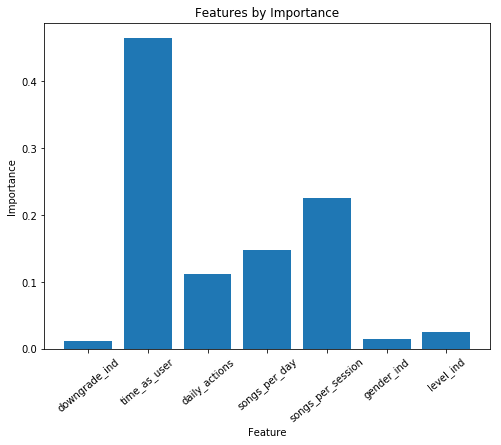

In [174]:
plt.figure(figsize=[8,6])
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, features, rotation=40)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Features by Importance');

# Conclusion

After observing, cleaning, and engineering features from the original data set, I was able to cut through a lot of noise in the data and narrow down to the best indicators of churn. Based on industry knowledge, I was confident that the best indicators for churn in subscription based productions is how long the person has been an user of the product and how much they use the product and the model confirmed that. 

Time as an user is very important because most people do not like change and this is why so many companies off lengthy free trials of a product of service. I've seen some companies offer a product or service freely for as much as 3 months! If you can get someone used to a product and build up features where the user and product almost know each other, this creates loyalty and makes the user less likely to start from scratch and try a similar product. Also, with a lot of the technological products we use, the amount of time we spend using and interacting with the product is a good indication on the liklihood of churn.

## Business Suggestions:
In terms of Sparkify, this information can be used to reward or incentivize users the longer they stay using the Sparkify and the daily or weekly amount of usage by the user. Since newer customers are more likely to churn, they could be provided a free trial of the premium service for maybe 60 days! It might even be more successful if the user can extend their free trial for up to a certain amount of time based on the amount of time they spend using Sparkify. I would also create some form of a time series to monitor the users usage and create a warning when the 7-day average for usage falls below a certain level. This level can be based on all users or there could be a different warning level based on other factors.

## Model Suggestions:
Given the data provided, if I had more time and data orver a longer period of time, I would take a look at some sort of time series analysis. I would create a variable that would track an users usage per day and week. My goal would be to look for constant decline or a flucuating pattern of usage. An user downgrading would definitely be something to create a warning on Sparkify's end.

Recommendation Engines would also come into play. There could be an opportunity to suggest artists similar to th artist(s) the user listens to the most and possible look at the time of day the user is most active on Sparkify to know when to send a notification.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.